In [66]:
import fcwt
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [67]:
# Load the audio file

audio_path = 'data/snare.wav'
y, sr = librosa.load(audio_path, sr=None)
print(y.shape, sr)
y = y[:int(sr*1)]


(15332,) 44100


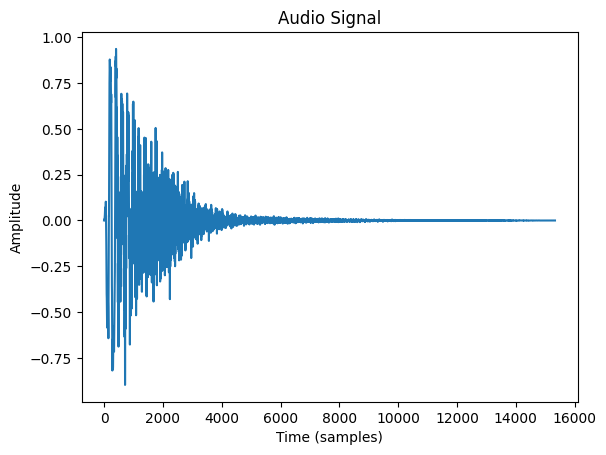

In [68]:
# plot the audio signal
plt.figure()
plt.plot(y)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.show()

In [69]:
import IPython
IPython.display.Audio(y, rate=sr)

In [70]:
# Compute the CWT
fn = 500
freqs, cwt = fcwt.cwt(y, sr, 20, 20000, fn, scaling='log', fast=True, norm=True)
print(cwt.shape)
cwt = np.abs(cwt)**2

(500, 15332)


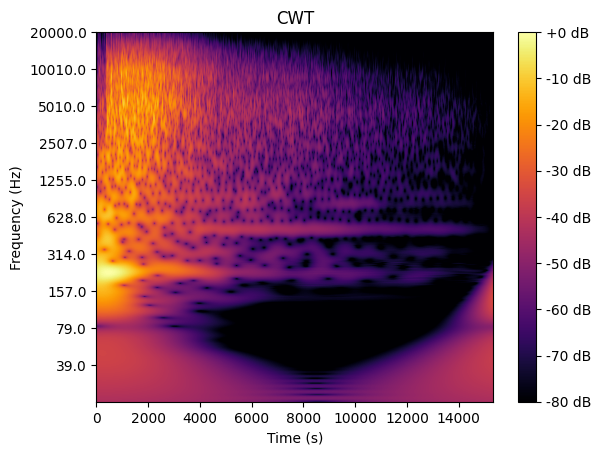

In [73]:
# Visualize the CWT
use_db_scale = True
cwt_dB = librosa.power_to_db(cwt, ref=np.max)
signal = cwt if not use_db_scale else cwt_dB
fig, ax = plt.subplots()
img = ax.imshow(signal, aspect='auto', cmap='inferno')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('CWT')
# ax.set_xticks(np.linspace(0,cwt_dB.size,10),np.arange(0,cwt_dB.size/sr,10))
ax.set_yticks(np.arange(0,fn,fn/10),np.round(freqs[::int(fn/10)]))
fig.colorbar(img, ax=ax, format='%+2.0f dB')
plt.show()

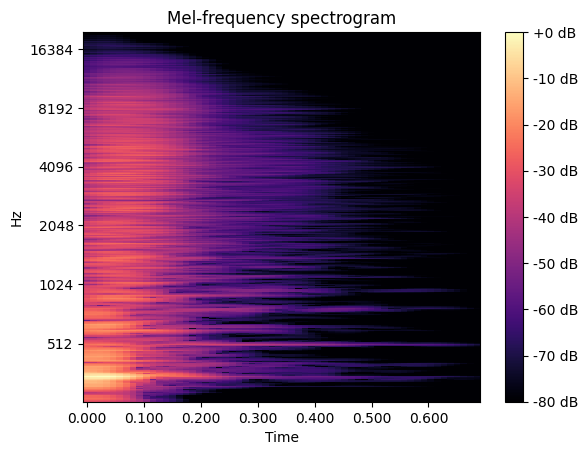

In [72]:
# show stft of the same signal
hop_length = 256
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=hop_length, n_mels=512)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
signal = S_dB if use_db_scale else S
img = librosa.display.specshow(signal, x_axis='time',
                                y_axis='mel', sr=sr,
                                fmin=20,
                                fmax=20000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()